# Модель

In [1]:
import pandas as pd
from json import loads, dumps
from ast import literal_eval
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random


In [2]:
df = pd.read_csv('/Users/ilya/Downloads/vacancies (1).csv').drop('Unnamed: 0', axis=1)


In [3]:
#Извлечем зарплату оттуда, где она в рублях
df['Salary'] = df.salary.apply(lambda x: literal_eval(x.replace('nan','None')).get('to') if ((pd.notnull(x)) and (literal_eval(x.replace('nan','None')).get('currency') == 'RUR')) else None)

In [4]:
df = df[df.Salary.notnull()].reset_index(drop=True)

In [5]:
education_exps = {'высшее': re.compile('высшее|бакалавр|магистр'), 'без опыта':re.compile('без опыта|нет опыта')}

Добавим признаки необходимость наличия высшего образования у кандидата и возможность приступить к работе не имея опыта:

In [6]:
df['req_высшее_образование'] = 0
df.loc[df.req.apply(lambda x: ((len(education_exps['высшее'].findall(x.lower())) > 0) & ('неполное высшее' not in x.lower())) if pd.notnull(x) else False), 'req_высшее_образование'] = 1

In [7]:
df['req_без_опыта'] = df.req.apply(lambda x: len(education_exps['без опыта'].findall(x))>0 if pd.notnull(x) else False).astype(int)

Обучим модель по tf-idf:

In [8]:
df = df[(df['name']+' '+df['req']+' '+df['resp']).notnull()]

In [20]:
features = (df['name']+' '+df['req']+' '+df['resp']).values

features = np.hstack((features.reshape(-1,1), df['req_высшее_образование'].values.reshape(-1,1)))
features = np.hstack((features, df['req_без_опыта'].values.reshape(-1,1)))
target = df.Salary.values

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,1), lowercase=True)

X_train_tfidf = tfidf.fit_transform(X_train[:,0])
X_test_tfidf = tfidf.transform(X_test[:,0])

In [23]:
import scipy
X_train = scipy.sparse.hstack((X_train_tfidf, X_train[:,1:].astype(float)))
X_test = scipy.sparse.hstack((X_test_tfidf, X_test[:,1:].astype(float)))

Гиперпараметры чуть подобраны

In [48]:
from xgboost import XGBRegressor

reg = XGBRegressor(max_depth=8, n_estimators=400)
reg.fit(X_train, y_train)

pred = reg.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Вычислим метрики и сравним предсказания со случаем, когда возвращается оптимальное константное значение (чтоб понимать, хорошо ли работает модель)

In [69]:
#RMSE:
np.sqrt(mean_squared_error(y_test, pred))

30755.266946549633

In [68]:
#Если возвращать константное оптимальное
np.sqrt(mean_squared_error(y_test, np.full(y_test.shape[0], y_test.mean())))

53818.141456132114

In [50]:
r2_score(y_test, pred)

0.67342599664669911

In [51]:
mean_absolute_error(y_test, pred)

16554.341216662724

In [63]:
#Если возвращать константное оптимальное
mean_absolute_error(y_test, np.full(y_test.shape[0], 45000))

28504.62935640887

r_2 (коэффициент детерминации) достаточно высок, чтобы принять модель достоверной.

#  Анализ

In [51]:
df[df.Salary.notnull()].Salary.quantile(0.95)

150000.0

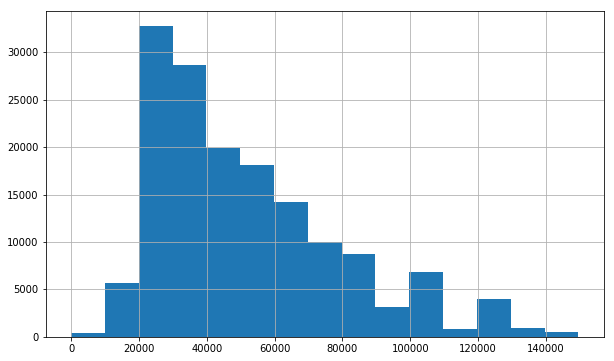

In [71]:
fig = plt.figure(figsize=(10,6))
df[((df.Salary.notnull()) & (df.Salary < 150000))].Salary.hist(bins=15);

Построим медианы зарплат для 17 городов с наибольшим количеством вакансий:

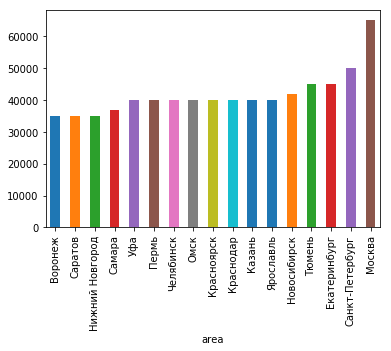

In [95]:
df[df.area.isin(df.area.value_counts().head(17).index)].groupby('area')['Salary'].median().sort_values().plot(kind='bar');

Среднее:

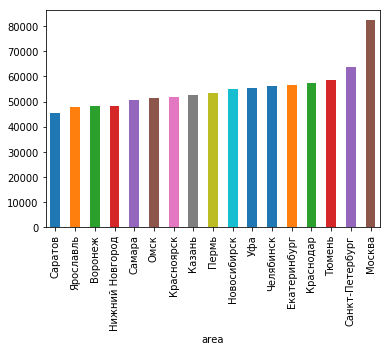

In [96]:
df[df.area.isin(df.area.value_counts().head(17).index)].groupby('area')['Salary'].mean().sort_values().plot(kind='bar');

Ожидаемо Москва и Спб - первые

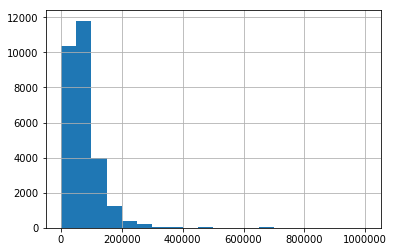

In [73]:
df[((df.area == 'Москва') & (pd.notnull(df.Salary)))].Salary.hist(bins=20)

Сравним зарплату, предлагаемую кандидатам на вакансиях, в которых требуется диплом топового университета, со средней зарплатой:

In [89]:
df[df.req.apply(lambda x: len(re.findall('мгу|вшэ|мфти|мгту|мгимо', x.lower())) > 0 if pd.notnull(x) else False) & (df.Salary.notnull())].Salary.median()

60000.0

In [90]:
df[~df.req.apply(lambda x: len(re.findall('мгу|вшэ|мфти|мгту|мгимо', x.lower())) > 0 if pd.notnull(x) else False) & (df.Salary.notnull())].Salary.median()

45000.0

Наиболее популярные вакансии:

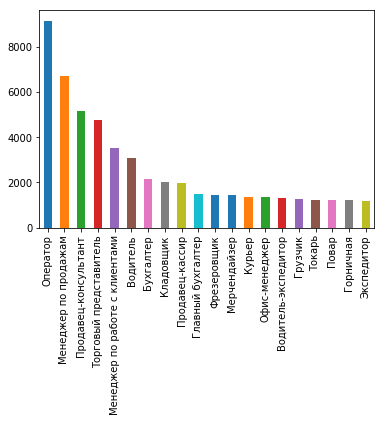

In [99]:
df.name.value_counts().head(20).plot(kind='bar')

Найдем наиболее и наименее высокооплачиваемые должности среди должностей, встретившихся в 200 или более вакансиях:

Наиболее:

In [89]:
df[df.name.isin(df.name.value_counts()[df.name.value_counts() > 200].index)].groupby('name')[['Salary']].median().sort_values('Salary', ascending=False).head(10)

,Salary
name,
Водитель,120000.0
Руководитель отдела продаж,100000.0
Водитель категории Е,85000.0
Программист 1С,85000.0
Машинист экскаватора,70000.0
Менеджер по оптовым продажам,70000.0
Менеджер отдела продаж,70000.0
Менеджер по продажам,70000.0
Фрезеровщик,65000.0


Наименее:

In [90]:
df[df.name.isin(df.name.value_counts()[df.name.value_counts() > 200].index)].groupby('name')[['Salary']].median().sort_values('Salary', ascending=True).head(10)

,Salary
name,
Горничная,20571.0
Продавец-кассир,22000.0
Оператор ПК,23700.0
Мерчендайзер,25000.0
Разнорабочий,25000.0
Грузчик,25000.0
Оператор,25000.0
Кассир,25300.0
Экспедитор,30000.0


In [141]:
df[df.name == 'Водитель'].Salary.median()

120000.0

In [143]:
df[df.area == 'Москва'].Salary.median()

65000.0

Сравним зарплаты четырех наиболее встречающиеся должностей в зависимости от города:

In [141]:
msc_jobs = df[df.area == 'Москва'][df[df.area == 'Москва'].name.isin(df[df.area == 'Москва'].name.value_counts()[df[df.area == 'Москва'].name.value_counts() > 20].index)].groupby('name')[['Salary']].median().sort_values('Salary', ascending=False)
kazan_jobs = df[df.area == 'Казань'][df[df.area == 'Казань'].name.isin(df[df.area == 'Казань'].name.value_counts()[df[df.area == 'Казань'].name.value_counts() > 20].index)].groupby('name')[['Salary']].median().sort_values('Salary', ascending=False)
novosib_jobs = df[df.area == 'Новосибирск'][df[df.area == 'Новосибирск'].name.isin(df[df.area == 'Новосибирск'].name.value_counts()[df[df.area == 'Новосибирск'].name.value_counts() > 20].index)].groupby('name')[['Salary']].median().sort_values('Salary', ascending=False)
ekb_jobs = df[df.area == 'Екатеринбург'][df[df.area == 'Екатеринбург'].name.isin(df[df.area == 'Екатеринбург'].name.value_counts()[df[df.area == 'Екатеринбург'].name.value_counts() > 20].index)].groupby('name')[['Salary']].median().sort_values('Salary', ascending=False)
spb_jobs = df[df.area == 'Санкт-Петербург'][df[df.area == 'Санкт-Петербург'].name.isin(df[df.area == 'Санкт-Петербург'].name.value_counts()[df[df.area == 'Санкт-Петербург'].name.value_counts() > 20].index)].groupby('name')[['Salary']].median().sort_values('Salary', ascending=False)

In [142]:
common_jobs = list(set(ekb_jobs.index) & set(novosib_jobs.index) & set(kazan_jobs.index) & set(msc_jobs.index) & set(spb_jobs.index))

In [143]:
msc_jobs = msc_jobs[msc_jobs.index.isin(common_jobs)].rename(columns={'Salary':'Москва'})
kazan_jobs = kazan_jobs[kazan_jobs.index.isin(common_jobs)].rename(columns={'Salary':'Казань'})
novosib_jobs = novosib_jobs[novosib_jobs.index.isin(common_jobs)].rename(columns={'Salary':'Новосибирск'})
ekb_jobs = ekb_jobs[ekb_jobs.index.isin(common_jobs)].rename(columns={'Salary':'Екатеринбург'})
spb_jobs = spb_jobs[spb_jobs.index.isin(common_jobs)].rename(columns={'Salary':'Санкт-Петербург'})

Text(0.5,1,'Зарплата в зависимости от региона')

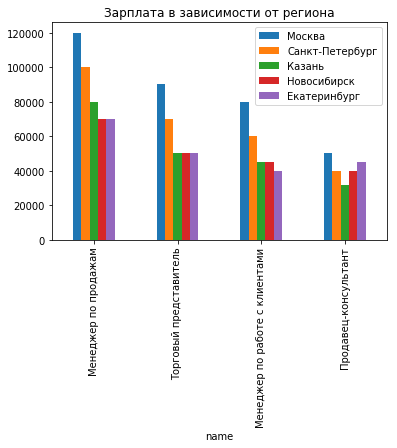

In [145]:
fig = plt.figure(figsize=(15, 8))
msc_jobs.merge(spb_jobs, left_index=True, right_index=True).merge(kazan_jobs, left_index=True, right_index=True).merge(novosib_jobs, left_index=True, right_index=True).merge(ekb_jobs, left_index=True, right_index=True).plot(kind='bar')
plt.title('Зарплата в зависимости от региона')

Как видно, в Москве и Спб на тех же должностях зарплаты выше, чем в регионах

Сравним зараплаты одного и того же работодателя (Пятерочка) и одной и той же вакансии (продавец-консультант) в зависимости от региона:

In [161]:
magaz = df[df.company_name == 'Пятерочка'].copy()

In [171]:
magaz['name'] = magaz.name.apply(lambda x: x.split('(')[0].strip())

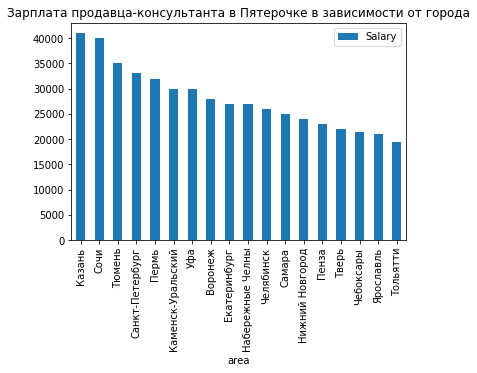

In [190]:
magaz[magaz.area.isin(magaz[magaz['name'] == 'Продавец-кассир'].area.value_counts()[magaz[magaz['name'] == 'Продавец-кассир'].area.value_counts() > 20].index)].groupby('area')[['Salary']].median().sort_values('Salary', ascending=False).plot(kind='bar', title='Зарплата продавца-консультанта в Пятерочке в зависимости от города')